# Import Libraries📚

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dense, LSTM, Dropout
from keras.models import Sequential
from tensorflow import keras
import os

np.random.seed(10)

# Data Preprocessing

In [74]:
data = pd.read_csv('Data/ETFs/vti.us.txt', delimiter=',')
data=data[['Date','Open','High','Low','Volume','Close']]
data.head()

,Date,Open,High,Low,Volume,Close
0,2005-02-25,51.657,52.187,51.638,572137,52.143
1,2005-02-28,52.143,52.153,51.629,234881,51.876
2,2005-03-01,51.966,52.235,51.966,102603,52.180
3,2005-03-02,51.893,52.431,51.893,225593,52.124
4,2005-03-03,52.229,52.390,51.902,145413,52.187


In [75]:
data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d')
data = data.set_index('Date')
data.head()

,Open,High,Low,Volume,Close
Date,,,,,
2005-02-25,51.657,52.187,51.638,572137,52.143
2005-02-28,52.143,52.153,51.629,234881,51.876
2005-03-01,51.966,52.235,51.966,102603,52.180
2005-03-02,51.893,52.431,51.893,225593,52.124
2005-03-03,52.229,52.390,51.902,145413,52.187


In [76]:
data.isnull().mean()

Open      0.0
High      0.0
Low       0.0
Volume    0.0
Close     0.0
dtype: float64

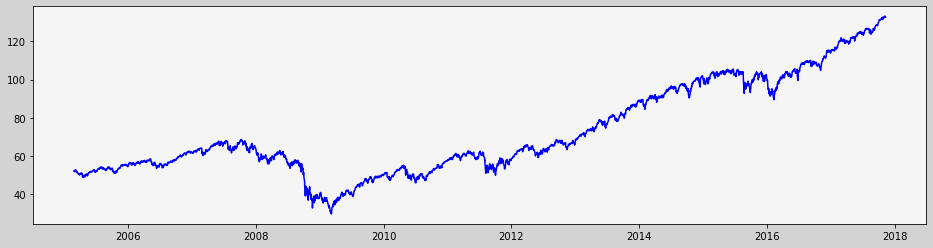

In [77]:
plt.figure(figsize=(16,4), facecolor='lightgrey')
ax = plt.axes()
ax.set_facecolor('whitesmoke')
plt.plot(data['Close'], color='blue')
plt.show()

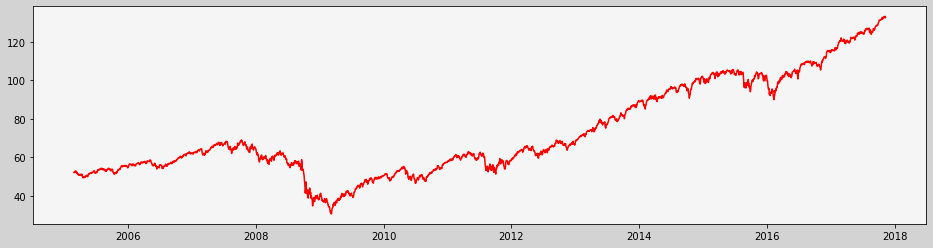

In [78]:
plt.figure(figsize=(16,4), facecolor='lightgrey')
ax = plt.axes()
ax.set_facecolor('whitesmoke')
plt.plot(data['High'], color='red')

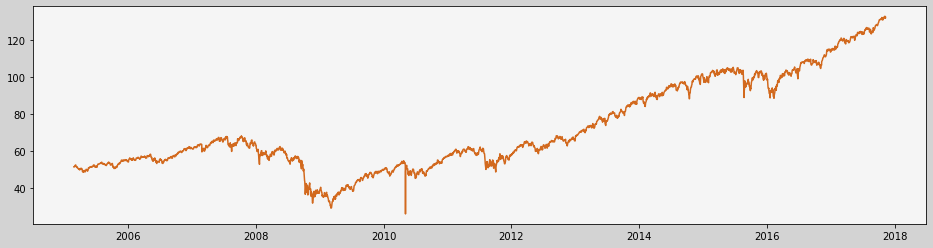

In [79]:
plt.figure(figsize=(16,4), facecolor='lightgrey')
ax = plt.axes()
ax.set_facecolor('whitesmoke')
plt.plot(data['Low'], color='chocolate')

In [80]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    dff = pd.DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(dff.shift(-i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(dff.shift(-i))
        if i==0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1)) for j in range(n_vars)]      
        agg = pd.concat(cols, axis=1)
        agg.columns = names
        if dropnan:
            agg.dropna(inplace=True)
        return agg

In [81]:
data_value = data.values
data_reframed = series_to_supervised(data_value)

In [82]:
pd.set_option('display.max_columns', None)
data_reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t),var2(t),var3(t),var4(t),var5(t)
0,52.143,52.153,51.629,234881.0,51.876,51.657,52.187,51.638,572137.0,52.143
1,51.966,52.235,51.966,102603.0,52.180,52.143,52.153,51.629,234881.0,51.876
2,51.893,52.431,51.893,225593.0,52.124,51.966,52.235,51.966,102603.0,52.180
3,52.229,52.390,51.902,145413.0,52.187,51.893,52.431,51.893,225593.0,52.124
4,52.439,52.788,52.390,241900.0,52.715,52.229,52.390,51.902,145413.0,52.187


In [83]:
data_reframed.drop(["var1(t)", "var2(t)", "var3(t)", "var4(t)"], inplace=True, axis=1)
data_reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var5(t)
0,52.143,52.153,51.629,234881.0,51.876,52.143
1,51.966,52.235,51.966,102603.0,52.180,51.876
2,51.893,52.431,51.893,225593.0,52.124,52.180
3,52.229,52.390,51.902,145413.0,52.187,52.124
4,52.439,52.788,52.390,241900.0,52.715,52.187


In [91]:
num = int(data_reframed.shape[0]*0.8)
value = data_reframed.values
train = value[:num, :]
test = value[num:, :]
scaler = MinMaxScaler(feature_range=(0,1))
train = scaler.fit_transform(train)
test = scaler.fit_transform(test)

In [92]:
train_x, train_y = train[:, :-1], train[:, -1]
test_x, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D
train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
test_x = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))
print(train_x.shape, test_x.shape )
print(train_y.shape, test_y.shape )

(2560, 1, 5) (640, 1, 5)
(2560,) (640,)


# LSTM Model

In [93]:
Model = Sequential()
Model.add(LSTM(150, input_shape=(train_x.shape[1], train_x.shape[2]), return_sequences=True))
Model.add(LSTM(40, return_sequences=True))
Model.add(Dropout(0.2))
Model.add(LSTM(10))
Model.add(Dense(1))
Model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 1, 150)            93600     
                                                                 
 lstm_10 (LSTM)              (None, 1, 40)             30560     
                                                                 
 dropout_3 (Dropout)         (None, 1, 40)             0         
                                                                 
 lstm_11 (LSTM)              (None, 10)                2040      
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 126,211
Trainable params: 126,211
Non-trainable params: 0
_________________________________________________________________


Epoch 1/15
40/40 [==============================] - 6s 42ms/step - loss: 0.1379 - val_loss: 0.0103
Epoch 2/15
40/40 [==============================] - 0s 6ms/step - loss: 0.0095 - val_loss: 0.0046
Epoch 3/15
40/40 [==============================] - 0s 6ms/step - loss: 0.0034 - val_loss: 0.0011
Epoch 4/15
40/40 [==============================] - 0s 6ms/step - loss: 0.0019 - val_loss: 5.6964e-04
Epoch 5/15
40/40 [==============================] - 0s 5ms/step - loss: 0.0016 - val_loss: 4.8134e-04
Epoch 6/15
40/40 [==============================] - 0s 6ms/step - loss: 0.0015 - val_loss: 4.5037e-04
Epoch 7/15
40/40 [==============================] - 0s 5ms/step - loss: 0.0013 - val_loss: 4.2228e-04
Epoch 8/15
40/40 [==============================] - 0s 9ms/step - loss: 0.0013 - val_loss: 4.6338e-04
Epoch 9/15
40/40 [==============================] - 0s 5ms/step - loss: 0.0011 - val_loss: 4.2084e-04
Epoch 10/15
40/40 [==============================] - 0s 6ms/step - loss: 0.0011 - val_loss: 4

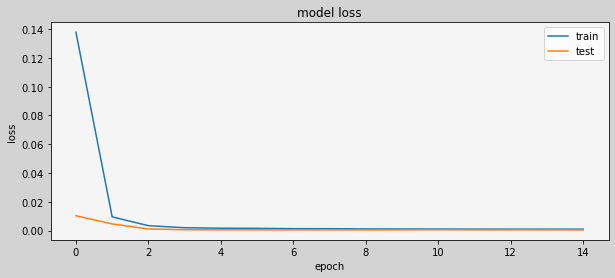

In [94]:
Model.compile(loss='mean_squared_error', optimizer='adam')
history = Model.fit(train_x, train_y, epochs=15, batch_size=64, validation_data=(test_x, test_y))
plt.figure(figsize=(10,4), facecolor='lightgrey')
ax = plt.axes()
ax.set_facecolor('whitesmoke')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [95]:
predict_y = Model.predict(test_x)

In [96]:
Model.save("Data/Models/");

INFO:tensorflow:Assets written to: Data/Models/assets


INFO:tensorflow:Assets written to: Data/Models/assets


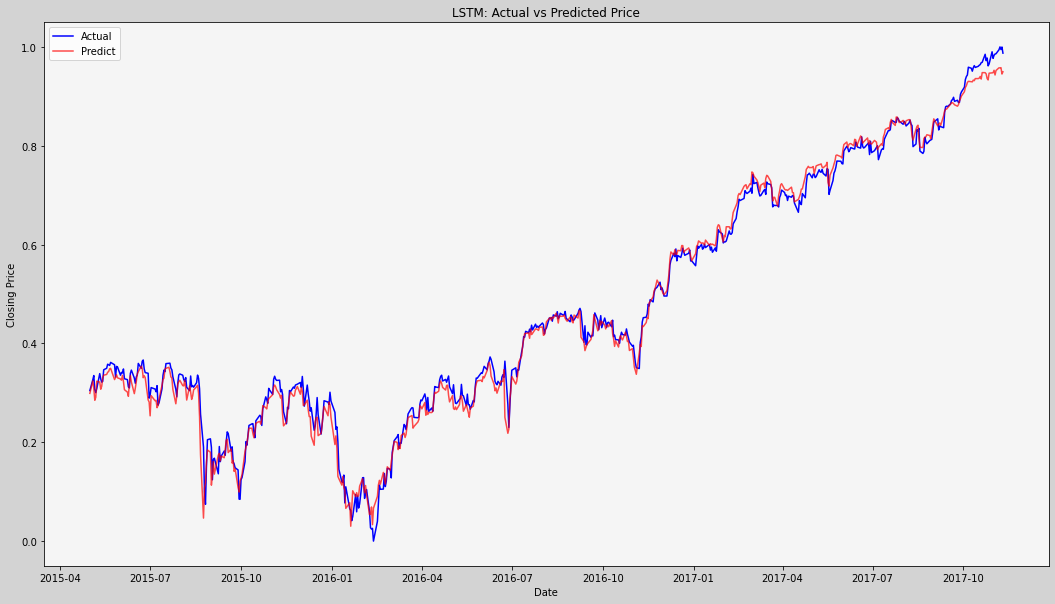

In [102]:
plt.figure(figsize=(18,10), facecolor='lightgrey')
ax = plt.axes()
ax.set_facecolor('whitesmoke')
plt.plot(data.index[-640:], test_y, color='blue',label='Actual')
plt.plot(data.index[-640:], predict_y, alpha=0.7, color='red',label='Predict')
plt.title('LSTM: Actual vs Predicted Price')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

In [98]:
#model evaluation
from sklearn.metrics import r2_score, mean_squared_error
print("R Squared Score: %.3f"%(r2_score(test_y, predict_y)))
print("Mean Square Error %.3f"%(mean_squared_error(test_y, predict_y)))

R Squared Score: 0.993
Mean Square Error 0.000
